<a href="https://colab.research.google.com/github/chrisamz/142-Final-Project/blob/main/PHYS142_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/1TJVSK3aUGGQ6amTyqyrE8NIjCR4_i9_o/view?usp=sharing

updates

8pm sat: 

i think rho and mcmc function are drafted for the most part, just unsure about the x_next calculation, and what $\Delta$ (`delta`) and $ɛ$ (`epsilon`) are?

```x_next = x_curr+(choice(path[i]) -0.5)*delta``` (?)
 - We are looking for a new point within a square of length $\Delta$, which is done by sampling uniformly in $[-\Delta/2, \Delta/2]$ for each axis. Python code would probably be something like `(np.random.rand(numdims) - 0.5)*delta`
 (see [numpy doc](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html))

# PHYS 142 Final Project (Prompt #2)
# Spr '22
## Group members:
### Christian Amezcua, Kentaro Hanson, Anastasia Ordonez

*Consider the double-well oscillator for quantum mechanical electron*

### (a)
*Evaluate the ground state energy $E_0$ from the Metropolis Monte Carlo path integral approximation for sufficiently large $\tau$ so that $E_0$ dominates*

In [5]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs # python adaptation of ARPACK
from scipy.sparse import spdiags
from random import randint
from random import random
from numpy.random import rand


#### parameters (taken from previous assignments)

In [6]:
m = 1
hbar = 1
omega = 1
#xmin = 1 / np.sqrt(alpha) # absolute value of potential well minima
#barrier = 1 / alpha # potential barrier height (unsure if necessary)

#sampling parameters
n_d = 600 # spatial resolution (num of points sampled)
x_0 = -4 # lower spatial bound
x_d = 4 # higher spatial bound
delta_x = (x_d - x_0) / n_d # spatial step size
x_size = n_d + 1 # total spatial steps
x = np.linspace(x_0, x_d, x_size) # (n_d + 1) vector of position points

N = 1000
T0 = 2*np.pi
delta_t = T0 / 128 # epsilon / time resolution (more precise, also called epsilon in notes)
t_size = 128 # total time steps
#t = np.linspace(0,t_size * tau,t_size)

In [21]:
# input vector of wave function/probability amplitude to normalize
def normalize(psi):
  #manually sum up (inner prod) and multiply by delta_x
  #(recall riemann sum)
  check = np.zeros(len(psi),dtype = np.complex64)
  for i in range(len(psi)):
    check[i] = np.conjugate(psi[i]) * psi[i] * delta_x
  Asquared = sum(check)  #if equal to 1, is normalized
  A = 1 / np.sqrt(Asquared) # normalization factor
  normalized_psi = A * psi
  return normalized_psi

# for graphing probability density of wavefunction
#def graph_prob_density(psi):
#  return np.real(np.conjugate(psi) * psi)

# double well potential
def double_well_potential(x):
  k = 2
  alpha = 0.4
  #ans = alpha * (x - xmin)**2 * (x + xmin)**2 # equivalent expression
  ans = -k * x**2 + alpha * x**4 + (1 / alpha)
  #xmin = 1 / np.sqrt(alpha) # absolute value of potential well minima
  return ans

In [23]:
1/np.sqrt(0.4)

1.5811388300841895

#### define probability density expression $\rho_\tau(x)$ and mcmc function to start choosing points

In [24]:
num_configs = 10000 # length of electron path aka number of configurations/points in path
n = 1 # dimension of configuration (here, 3d as shown above)

markovtime = [i for i in range(num_configs)]

#creates path that will be used to calculate E0
def mcmc(rho_func,num_configs,n,delta=0.6,x_init=None):
  """returns FULL path markov chain starting with a random point in range
    
    - rho_func       prob density function
    - num_samples   number of samples to take (len(path))
    
    - n             dimensions of coordinates

    - delta         (optional) the length of the hypercube to sample from as in
                    the metropolis update. (default: 1)

  """
  #initialize path matrix/array of arrays representing the coordinates
  #will update in MCMC code as we continuously choose next position
  path = np.zeros((num_configs, n),dtype=np.float64)
  #choose starting point (random)
  #from parameters: x_0 = -4 and x_d = 4
  if x_init == None:
    path[0] = [0 for i in range(n)]
  else:
    path[0] = x_init
  path[num_configs - 1] = path[0] # initial position = final position of electron
  print("initial and final position of electron: ",path[0])
  
  #initialize energy vector and prob dens(same length as path)
  E = np.zeros(num_configs,dtype=np.float64)
  r = np.zeros(num_configs,dtype=np.float64)

  #start making path
  for i in range(len(path) - 1): #don't do last one, since already defined by the periodic condition
    a = 0
    x_curr = path[i] #current position
    path[i+1] = x_curr #dummy next position
    for xi in range(n): #iterate through each coord/config dimension e.g (x0,x1,x2)
      
      while a != 1:
        #find next position
        xi_next = x_curr[xi] + (random() - 0.5) * delta
        x_trial = path[i+1]
        x_trial[xi] = xi_next #replaces x0,x1,...or xn in current coordinate

        #calculate probability density and E for trial coord/config
        rho_prime = rho_func(x_trial)
        rho_curr = rho_func(x_curr)
        
        #compare above for acceptance process
        # AXX' is `a`
        if rho_prime[0] >= rho_curr[0]:
          #accept
          a = 1
          #record/update prime (next) energy and probabilty density
          E[i+1] = rho_prime[1]
          r[i+1] = rho_prime[0]
        else:
          a = rho_prime[0] / rho_curr[0]
          if random() < a: #generate random # and accept if r < AXX'
            a = 1
            #record/update prime (next) energy and probabilty density
            E[i+1] = rho_prime[1]
            r[i+1] = rho_prime[0]

      #new coord is chosen! update/reset AXX' and choose next
      path[i+1][xi] = xi_next
      a = 0
  return path, E, r

In [ ]:
#helper method to mcmc
#calculate probability density for each configuration/coordinate in choosing process

#we want big tau (tau = N*epsilon)
def rho(coord, epsilon=delta_t):
  """returns probability density [0] and total E [1] for given coordinate/configuration
       for double well potential

    - coord     coordinate or configuration for calculation

    - epsilon   (default = delta_t) time resolution (?)

  """
  if hasattr(coord,"__len__"): #coord is a vector
    n = len(coord) # dimensions of coord

    #kinetic energy
    kesum = [(coord[i] - coord[i-1])**2 for i in range(1,len(coord))]
    kesum.append( (coord[ len(coord)-1 ] - coord[0])**2 ) #closed ring (? referring to lab session may 26)
    ke = m /(2*hbar*epsilon) * sum(kesum)

    #potential energy
    #`vvariable` replaces `x` in the potential energy formula for
    # `1/2 * (x[i-1] + x[i])`
    vvariable = [1/2 * (coord[i-1] + coord[i]) for i in range(1,len(coord))]
    vvariable.append(1/2 * (coord[ len(coord) - 1 ] + coord[0]) ) #closed ring
    vsum = [double_well_potential(vvariable[i]) for i in range(len(vvariable))]
    v = epsilon / hbar * sum(vsum)

  else: #coord single dimension
    n = 1 # dimensions of coord

    #kinetic energy
    ke = m /(2*hbar*epsilon) * coord**2
    
    #potential energy
    v = epsilon / hbar * double_well_potential(coord)

  #total E *tau = (K + V )*tau
  etotaltau = ke + v
  tau = n*epsilon
  rho = np.exp(-etotaltau) #probability density = exp(-E*tau)

  return rho, etotaltau / tau

In [197]:
[path1,E1, r1] = mcmc(rho,num_configs,n) # without tau exp
#[path2,E2,r2] = mcmc(rhotau,num_configs,n) # with tau exp

initial and final position of electron:  [0.]


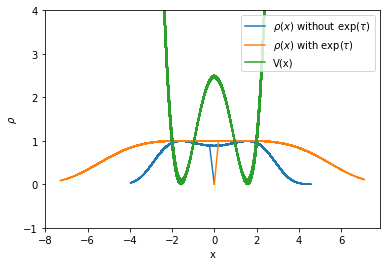

In [189]:
plt.plot(path1,r1,label=r"$\rho(x)$ without exp($\tau$)")
plt.plot(path1,double_well_potential(path1),label="V(x)")
plt.ylim([-1,4])
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\rho$")
plt.show()

No handles with labels found to put in legend.


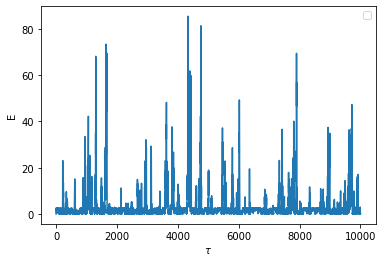

In [198]:
plt.plot([i for i in range(num_configs)],E1)
#plt.plot([i for i in range(num_configs)],E2,label=r"with exp($\tau$)")
plt.xlabel(r"$\tau$")
plt.ylabel("E")
#plt.legend()
plt.show()

In [9]:
#trying to fix and make clearer
def rho2(coord, epsilon=delta_t):
  """returns probability density [0] and total E [1] for given coordinate/configuration
       for double well potential

    - coord     coordinate or configuration for calculation

    - epsilon   (default = delta_t) time resolution (?)

  """
  if hasattr(coord,"__len__"): #coord is a vector
    n = len(coord) # dimensions of coord

    #kinetic energy
    kesum = [(coord[i] - coord[i-1])**2 for i in range(1,len(coord))]
    kesum.append( (coord[ len(coord)-1 ] - coord[0])**2 ) #closed ring (? referring to lab session may 26)
    ke = m /(2*epsilon**2) * sum(kesum)

    #potential energy
    #`vvariable` replaces `x` in the potential energy formula for
    # `1/2 * (x[i-1] + x[i])`
    vvariable = [1/2 * (coord[i-1] + coord[i]) for i in range(1,len(coord))]
    vvariable.append(1/2 * (coord[ len(coord) - 1 ] + coord[0]) ) #closed ring
    vsum = [double_well_potential(vvariable[i]) for i in range(len(vvariable))]
    v = sum(vsum)

  else: #coord single dimension
    n = 1 # dimensions of coord

    #kinetic energy
    ke = m /(2*epsilon**2) * coord**2
    
    #potential energy
    v = double_well_potential(coord)

  #total E *tau = (K + V )*tau
  etotal = (ke + v) / n
  tau = n*epsilon
  rho = np.exp(-etotal*tau) #probability density = exp(-E*tau)

  return rho, etotal

initial and final position of electron:  [1.58]


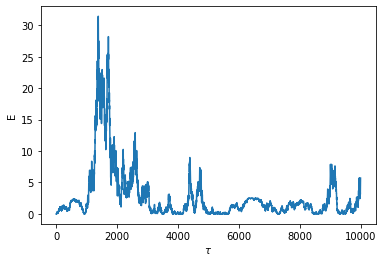

In [33]:
num_configs = 10000
[path2,E2,r2] = mcmc(rho2,num_configs,n,delta = 0.1, x_init = 1.58)
plt.plot([i for i in range(num_configs)],E2)
plt.xlabel(r"$\tau$")
plt.ylabel("E")
#plt.legend()
plt.show()

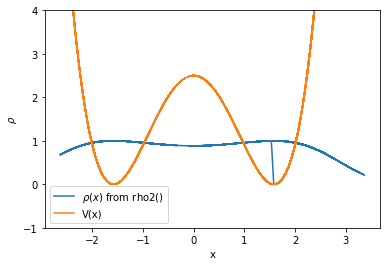

In [34]:
plt.plot(path2,r2,label=r"$\rho(x)$ from rho2()")
plt.plot(path2,double_well_potential(path2),label="V(x)")
plt.ylim([-1,4])
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\rho$")
plt.show()

#### disregard

In [186]:
#helper method to mcmc
#calculate probability density for each configuration/coordinate in choosing process

#we want big tau (tau = N*epsilon)
def rhotau(coord, epsilon=delta_t):
  """returns probability density [0] and total E [1] for given coordinate/configuration
       for double well potential

    - coord     coordinate or configuration for calculation

    - epsilon   (default = delta_t) time resolution (?)

  """
  if hasattr(coord,"__len__"): #coord is a vector
    n = len(coord) # dimensions of coord

    #kinetic energy
    kesum = [(coord[i] - coord[i-1])**2 for i in range(1,len(coord))]
    kesum.append( (coord[ len(coord)-1 ] - coord[0])**2 ) #closed ring (? referring to lab session may 26)
    ke = m /(2*hbar*epsilon) * sum(kesum)

    #potential energy
    #`vvariable` replaces `x` in the potential energy formula for
    # `1/2 * (x[i-1] + x[i])`
    vvariable = [1/2 * (coord[i-1] + coord[i]) for i in range(1,len(coord))]
    vvariable.append(1/2 * (coord[ len(coord) - 1 ] + coord[0]) ) #closed ring
    vsum = [double_well_potential(vvariable[i]) for i in range(len(vvariable))]
    v = epsilon / hbar * sum(vsum)

  else: #coord single dimension
    n = 1 # dimensions of coord

    #kinetic energy
    ke = m /(2*hbar*epsilon) * coord**2
    
    #potential energy
    v = epsilon / hbar * double_well_potential(coord)

  #total E = K + V
  etotal = ke + v
  tau = n*epsilon
  rho = np.exp(-etotal*tau) #probability density = exp(-E*tau)

  return rho, etotal

### (b)
*Plot the ground state probability distribution*

In [ ]:
plt.plot(x,vx,'k--',label="V")
plt.xlabel("x")
plt.ylabel(r"$\psi$")
plt.legend()
plt.show()

### (c)
*Can you calculate the average energy $<E>$ of the electron from the same simulation code when $\tau$ is much lower than in (a)*

### (d)
*Evaluate from the MC code (follow the hint) the probabilty distribution $\rho(x) = Σ \vert \psi_n(x)\vert^2 * p_n$ toward the $\tau → ∞$*